In [114]:
import numpy as np
import sympy as sp
import pandas as pd
from scipy.integrate import solve_ivp
import seaborn as sns
import matplotlib.pyplot as plt

In [115]:
t = sp.symbols('t')
mu1, mu2, mu3 = sp.symbols('mu1 mu2 mu3', cls=sp.Function)
mu1 = mu1(t); mu2 = mu2(t); mu3 = mu3(t)

x1, x2, lam = sp.symbols('x1 x2 lam')
z = sp.Matrix([x1, x2, lam])
mu = sp.Matrix([mu1, mu2, mu3])


In [116]:
# drift at mean
f1 = x1 - x1**3 + lam
f2 = -x2 + x1**2
f3 = 0
f = sp.Matrix([f1, f2, f3])


In [117]:
# jacobian evaluated at mean
J = f.jacobian(z)
J_mu = J.subs(dict(zip(z, mu)))

In [118]:
sigma = sp.symbols('sigma', positive=True)
sigma_sq = sigma**2 # variance of noise
Q = sp.diag(sigma_sq, sigma_sq, 0) # only noise in x1 and x2
mu_dot = f.subs(dict(zip(z, mu)))

Sigma = sp.MatrixSymbol('Sigma', 3, 3)  # covariance matrix
Sigma_dot = J_mu * Sigma + Sigma * J_mu.T + Q

In [119]:
mean_odes = [
    sp.Eq(sp.diff(mu1, t), mu_dot[0]),
    sp.Eq(sp.diff(mu2, t), mu_dot[1]),
    sp.Eq(sp.diff(mu3, t), mu_dot[2])
]

cov_odes = [
    sp.Eq(sp.Derivative(Sigma[i, j], t), sp.simplify(Sigma_dot[i, j]))
    for i in range(3) for j in range(3)
]

from IPython.display import display, Math
for ode in mean_odes + cov_odes:
    display(Math(sp.latex(ode)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [120]:
# params
T = 10.0
dt = 0.01
steps = int(T / dt)
times = np.linspace(0, T, steps)
num_neurons = 5000
sigma = 0.2
lambda_val = 0.5

In [121]:
X = np.zeros((steps, num_neurons, 2)) # [time, neurons, (x1, x2)]
X[0, :, :] = np.random.randn(num_neurons, 2) * 0.1 # small init perturbation

# drift function
def f(x1, x2, lam):
    dx1 = x1 - x1**3 + lam
    dx2 = -x2 + x1**2
    return np.stack([dx1, dx2], axis=-1)

In [122]:
# simulate ensemble
for n in range(steps - 1):
    x1 = X[n, :, 0]
    x2 = X[n, :, 1]
    drift = f(x1, x2, lambda_val)
    noise = sigma * np.sqrt(dt) * np.random.randn(num_neurons, 2)
    X[n+1, :, :] = X[n, :, :] + drift * dt + noise

In [123]:
# compute empirical mean and cov
mu_emp = np.mean(X, axis=1)
var_emp = np.var(X, axis=1)

def moment_odes(t, y):
    mu1, mu2, mu3, s11, s12, s22 = y
    dmu1 = mu1 - mu1**3 + mu3
    dmu2 = -mu2 + mu1**2
    dmu3 = 0

    J = np.array([
        [1 - 3*mu1**2, 0],
        [2*mu1, -1]
    ])
    Sigma = np.array([
        [s11, s12],
        [s12, s22]
    ])
    Q = np.diag([sigma**2, sigma**2])
    dSigma = J @ Sigma + Sigma @ J.T + Q

    ds11 = dSigma[0, 0]
    ds12 = dSigma[0, 1]
    ds22 = dSigma[1, 1]

    return [dmu1, dmu2, dmu3, ds11, ds12, ds22]

y0 = [0.0, 0.0, lambda_val, 0.01, 0.0, 0.01] # initial conditions for mu and Sigma
sol = solve_ivp(moment_odes, [0, T], y0, t_eval=times)


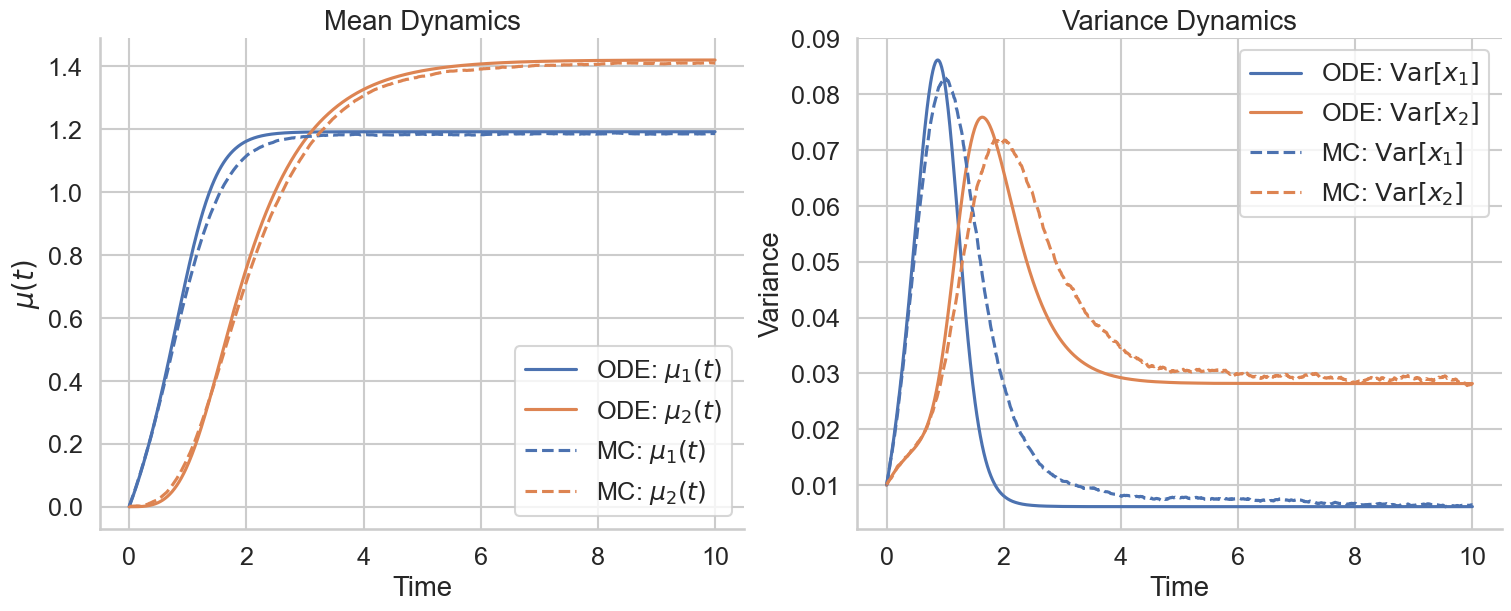

In [124]:

sns.set_theme(style='whitegrid', context='talk', font_scale=1.1)

fig, axes = plt.subplots(1, 2, figsize=(15, 6), constrained_layout=True)

axes[0].plot(times, sol.y[0], label='ODE: $\\mu_1(t)$', color='C0')
axes[0].plot(times, sol.y[1], label='ODE: $\\mu_2(t)$', color='C1')
axes[0].plot(times, mu_emp[:, 0], '--', label='MC: $\\mu_1(t)$', color='C0')
axes[0].plot(times, mu_emp[:, 1], '--', label='MC: $\\mu_2(t)$', color='C1')
axes[0].set_title('Mean Dynamics')
axes[0].set_xlabel('Time')
axes[0].set_ylabel('$\\mu(t)$')
axes[0].legend()

axes[1].plot(times, sol.y[3], label='ODE: $\\mathrm{Var}[x_1]$', color='C0')
axes[1].plot(times, sol.y[5], label='ODE: $\\mathrm{Var}[x_2]$', color='C1')
axes[1].plot(times, var_emp[:, 0], '--', label='MC: $\\mathrm{Var}[x_1]$', color='C0')
axes[1].plot(times, var_emp[:, 1], '--', label='MC: $\\mathrm{Var}[x_2]$', color='C1')
axes[1].set_title('Variance Dynamics')
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Variance')
axes[1].legend()

sns.despine()
plt.show()

In [125]:
# generate dataset
data_rows = []
lambda_vals = np.linspace(-1, 1, 21)

for lambda_val in lambda_vals:
    X = np.zeros((steps, num_neurons, 2))
    X[0] = np.random.randn(num_neurons, 2) * 0.1

    for n in range(steps - 1):
        x1 = X[n, :, 0]
        x2 = X[n, :, 1]
        drift = f(x1, x2, lambda_val)
        noise = sigma * np.sqrt(dt) * np.random.randn(num_neurons, 2)
        X[n+1] = X[n] + drift * dt + noise

    for n in range(steps):
        mu = np.mean(X[n], axis=0)
        cov = np.cov(X[n].T)
        row = {
            'lambda': lambda_val,
            'time': times[n],
            'mu1': mu[0],
            'mu2': mu[1],
            'cov11': cov[0, 0],
            'cov12': cov[0, 1],
            'cov22': cov[1, 1]
        }
        data_rows.append(row)
    
df = pd.DataFrame(data_rows)
print(df.shape)
df.to_csv('lambda_time_stats.csv', index=False)
df.head()

(21000, 7)


,lambda,time,mu1,mu2,cov11,cov12,cov22
0,-1.0,0.00000,0.001065,-0.002462,0.009661,0.000050,0.010171
1,-1.0,0.01001,-0.008771,-0.002119,0.010205,-0.000007,0.010393
2,-1.0,0.02002,-0.019357,-0.002043,0.010837,-0.000078,0.010656
3,-1.0,0.03003,-0.029915,-0.002149,0.011357,-0.000066,0.010766
4,-1.0,0.04004,-0.040111,-0.001928,0.011926,-0.000075,0.010819


In [137]:
from sklearn.linear_model import Ridge
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

data = pd.read_csv('lambda_time_stats.csv')
X = data[['lambda', 'time']].values
y = data[['mu1', 'mu2', 'cov11', 'cov12', 'cov22']].values

In [138]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = Ridge(alpha=0.7)
model.fit(X_train, y_train)

Ridge(alpha=0.7)

In [139]:
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Ridge Regression MSE: {mse:.4f}, R^2: {r2:.4f}')

Ridge Regression MSE: 0.0668, R^2: 0.2979


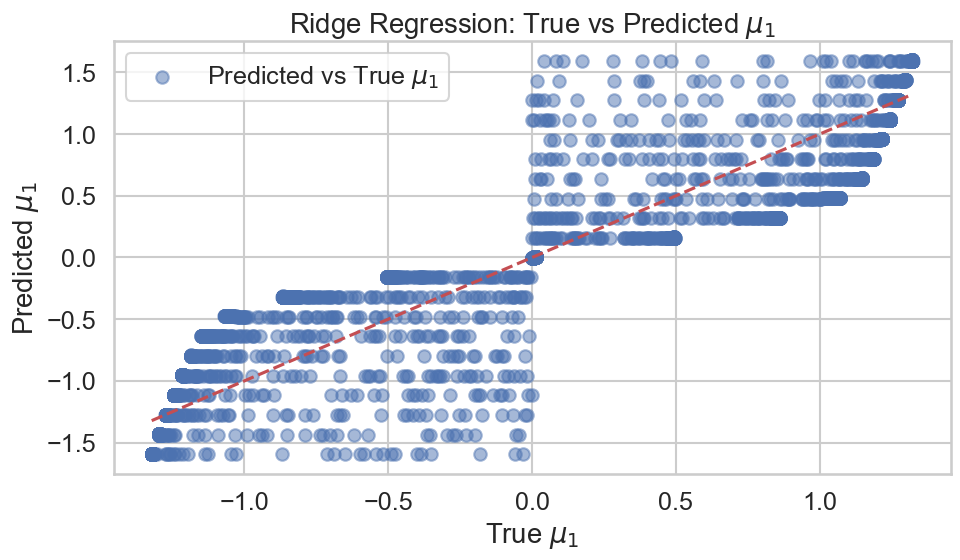

In [140]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test[:, 0], y_pred[:, 0], alpha=0.5, label='Predicted vs True $\\mu_1$')
plt.plot([y_test[:, 0].min(), y_test[:, 0].max()], [y_test[:, 0].min(), y_test[:, 0].max()], 'r--')
plt.xlabel('True $\\mu_1$')
plt.ylabel('Predicted $\\mu_1$')
plt.title('Ridge Regression: True vs Predicted $\\mu_1$')
plt.legend()
plt.tight_layout()
plt.show()

In [156]:
# switch to pytorch since i want live plotting
import torch
import torch.nn as nn
import torch.optim as optim
from IPython.display import clear_output
from sklearn.decomposition import PCA

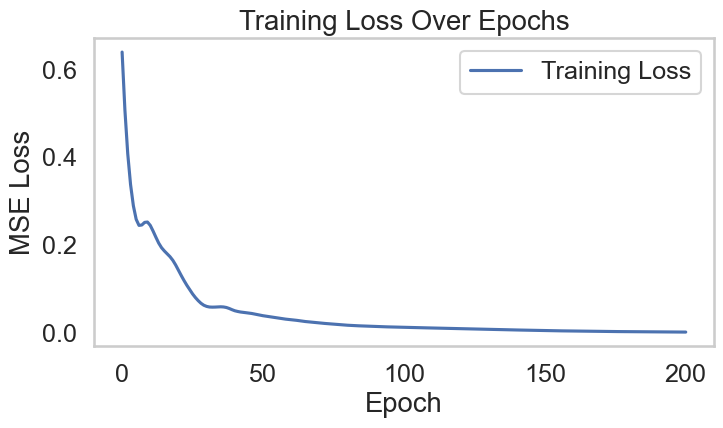

Early stopping at epoch 204, loss: 0.000985
Final loss after 205 epochs: 0.000985


TypeError: 'int' object is not callable

In [ ]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

pca = PCA()
y_train_tensor_pca = pca.fit_transform(y_train_tensor)

print(X_train_tensor.shape, y_train_tensor.shape)
print(X_test_tensor.shape, y_test_tensor.shape)

class FeedForwardNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(X_train.shape[1], 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 5) # 5 outputs: mu1, mu2, cov11, cov12, cov22
        )
    def forward(self, x):
        return self.net(x)

model = FeedForwardNN()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

losses = []
epochs = 500
loss_threshold = 1e-3
for epoch in range(epochs):
    optimizer.zero_grad()
    output = model(X_train_tensor)
    loss = criterion(output, y_train_tensor)

    if loss.item() < loss_threshold:
        print(f'Early stopping at epoch {epoch}, loss: {loss.item():.6f}')
        break

    loss.backward()
    optimizer.step()

    losses.append(loss.item())

    # plot
    if epoch % 5 == 0:
        clear_output(wait=True)
        plt.figure(figsize=(8, 4))
        plt.plot(losses, label='Training Loss')
        plt.xlabel('Epoch')
        plt.ylabel('MSE Loss')
        plt.title('Training Loss Over Epochs')
        plt.legend()
        plt.grid()
        plt.show()

print(f'Final loss after {epoch+1} epochs: {loss.item():.6f}')
    
# Final evaluation
y_pred_tensor_pca = model(X_test_tensor).detach().numpy()
y_pred_numpy = pca.inverse_transform(y_pred_tensor_pca)
y_pred_tensor = torch.tensor(y_pred_numpy, dtype=torch.float32)
mse = criterion(y_pred_tensor, y_test_tensor).item()
r2 = r2_score(y_test_tensor.detach().numpy(), y_pred_tensor.detach().numpy(), multioutput='raw_values')
print(f'Final MSE: {mse:.4f}, Mean R^2: {np.mean(r2):.4f}')
for i, name in enumerate(['mu1', 'mu2', 'cov11', 'cov12', 'cov22']):
    print(f'R^2 for {name}: {r2[i]:.4f}')

output_labels = [r'$\mu_1$', r'$\mu_2$', r'$\Sigma_{11}$', r'$\Sigma_{12}$', r'$\Sigma_{22}$']

plt.figure(figsize=(16, 10))

for i in range(5):
    plt.subplot(2, 3, i+1)
    y_true = y_test_tensor[:, i].detach().numpy()
    y_pred = y_pred_tensor[:, i].detach().numpy()
    
    plt.scatter(y_true, y_pred, alpha=0.5, label=f'Predicted vs True {output_labels[i]}')
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
    
    plt.xlabel(f'True {output_labels[i]}')
    plt.ylabel(f'Predicted {output_labels[i]}')
    plt.title(f'True vs Predicted {output_labels[i]}')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()
